In [1]:
# !pip install tensorflow==2.6.2
# !pip install keras==2.6.0 
# !pip install gensim==4.1.2 
# !pip install nltk==3.8.1 
# !pip install rouge==1.0.1 

In [2]:
import os
import pandas as pd
from nltk.corpus import stopwords
import nltk
from string import punctuation
import gensim
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.layers import Dense, LSTM, Dropout, Input, Activation, Add, concatenate, Embedding, RepeatVector
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import math

In [3]:
def remove_punc(string):

    punctuation_zh = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·"""
    dicts = {i: '' for i in punctuation + punctuation_zh}
    punc_table = str.maketrans(dicts)
    return string.translate(punc_table)

In [4]:
stop_words = stopwords.words('english')

In [5]:
def preprocess(line):
    temp = []
    cut_text = list(nltk.word_tokenize(line))
    for word in cut_text:
        if word in stop_words:
            continue
        word = remove_punc(word).strip()
        if not word:
            continue
        temp.append(word)
    return temp

In [6]:
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")
data = pd.concat([train_data, val_data, test_data], ignore_index=True)

In [7]:
data

,class,article,summary
0,entertainment,Top of the Pops leaves BBC OneThe BBC's flagsh...,The BBC's flagship pop music programme Top of ...
1,entertainment,Snow Patrol feted at Irish awardsSnow Patrol w...,Franz Ferdinand picked up best international b...
2,entertainment,Godzilla gets Hollywood fame starMovie monster...,"""Godzilla should thank you for this historical..."
3,entertainment,Children vote Shrek 2 best filmYoung UK film f...,Young UK film fans voted animated Hollywood hi...
4,entertainment,Franz Ferdinand's art school lessonScottish ro...,The buzz about the band soon spread around the...
...,...,...,...
2220,tech,Cable offers video-on-demandCable firms NTL an...,Cable firms NTL and Telewest have both launche...
2221,tech,Anti-spam laws bite spammer hardThe net's self...,OptInRealBig was fighting several legal battle...
2222,tech,Telewest to challenge Sky PlusCable firm Telew...,Cable firm Telewest is to offer a personal vid...
2223,tech,Halo fans' hope for sequelXbox video game Halo...,Xbox video game Halo 2 has been released in th...


In [8]:
data["article_clean"] = data["article"].apply(preprocess)
data["summary_clean"] = data["summary"].apply(preprocess)

In [9]:
data

,class,article,summary,article_clean,summary_clean
0,entertainment,Top of the Pops leaves BBC OneThe BBC's flagsh...,The BBC's flagship pop music programme Top of ...,"[Top, Pops, leaves, BBC, OneThe, BBC, s, flags...","[The, BBC, s, flagship, pop, music, programme,..."
1,entertainment,Snow Patrol feted at Irish awardsSnow Patrol w...,Franz Ferdinand picked up best international b...,"[Snow, Patrol, feted, Irish, awardsSnow, Patro...","[Franz, Ferdinand, picked, best, international..."
2,entertainment,Godzilla gets Hollywood fame starMovie monster...,"""Godzilla should thank you for this historical...","[Godzilla, gets, Hollywood, fame, starMovie, m...","[Godzilla, thank, historical, monumental, star..."
3,entertainment,Children vote Shrek 2 best filmYoung UK film f...,Young UK film fans voted animated Hollywood hi...,"[Children, vote, Shrek, 2, best, filmYoung, UK...","[Young, UK, film, fans, voted, animated, Holly..."
4,entertainment,Franz Ferdinand's art school lessonScottish ro...,The buzz about the band soon spread around the...,"[Franz, Ferdinand, s, art, school, lessonScott...","[The, buzz, band, soon, spread, around, music,..."
...,...,...,...,...,...
2220,tech,Cable offers video-on-demandCable firms NTL an...,Cable firms NTL and Telewest have both launche...,"[Cable, offers, videoondemandCable, firms, NTL...","[Cable, firms, NTL, Telewest, launched, videoo..."
2221,tech,Anti-spam laws bite spammer hardThe net's self...,OptInRealBig was fighting several legal battle...,"[Antispam, laws, bite, spammer, hardThe, net, ...","[OptInRealBig, fighting, several, legal, battl..."
2222,tech,Telewest to challenge Sky PlusCable firm Telew...,Cable firm Telewest is to offer a personal vid...,"[Telewest, challenge, Sky, PlusCable, firm, Te...","[Cable, firm, Telewest, offer, personal, video..."
2223,tech,Halo fans' hope for sequelXbox video game Halo...,Xbox video game Halo 2 has been released in th...,"[Halo, fans, hope, sequelXbox, video, game, Ha...","[Xbox, video, game, Halo, 2, released, US, 9, ..."


In [10]:
Word2VecModel = gensim.models.Word2Vec(
    [eval(str(i)) for i in data['article_clean']] +
    [eval(str(i)) for i in data['summary_clean']],
    vector_size=300,
    window=5,
    min_count=20,
    workers=5)  

In [11]:
len(Word2VecModel.wv.key_to_index.keys())

5496

In [12]:
Word2VecModel.save('w2v.model')

In [13]:
Word2VecModel = gensim.models.Word2Vec.load("w2v.model")

In [14]:

vocab_list = list(Word2VecModel.wv.key_to_index.keys())

embeddings_matrix = np.zeros((len(vocab_list) + 1, Word2VecModel.vector_size))

for i in range(len(vocab_list)):
    word = vocab_list[i]
    embeddings_matrix[i] = Word2VecModel.wv[word]
vocab_size = len(vocab_list) + 1

In [15]:
vocab_size

5497

In [16]:
max_input_length = 128
X = []
for text in data['article_clean']:
    text = eval(str(text))
    temp = []
    for word in text:
        if word not in Word2VecModel.wv.key_to_index:
            temp.append(vocab_size - 1)
        else:
            temp.append(Word2VecModel.wv.key_to_index[word])
    if len(temp) < max_input_length:
        temp += [vocab_size - 1] * (max_input_length - len(temp))
    else:
        temp = temp[:max_input_length]
    X.append(temp)
article_X = np.array(X)

max_target_length = 64 + 1
X = []
for text in data['summary_clean']:
    text = eval(str(text))
    temp = []
    for word in text:
        if word not in Word2VecModel.wv.key_to_index:
            temp.append(vocab_size - 1)
        else:
            temp.append(Word2VecModel.wv.key_to_index[word])
    if len(temp) < max_target_length:
        temp += [vocab_size - 1] * (max_target_length - len(temp))
    else:
        temp = temp[:max_target_length]
    X.append(temp)
summary_X = np.array(X)

In [17]:
article_X.shape, summary_X.shape

((2225, 128), (2225, 65))

In [18]:
embedding_size = 300 
lstm_units = 256  
batch_size = 64 
epochs = 50
learning_rate = 0.001 
dropout_rate = 0.5  

inputs = Input(shape=(max_input_length,))  
x = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length = max_input_length,
                                    weights = [embeddings_matrix],
                                    trainable = True)(inputs)  
x = Dropout(dropout_rate)(x)  
encoder_outputs, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(x)  
encoder_states = [state_h, state_c]  
decoder_inputs = Input(shape=(max_target_length - 1,))
y = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length = max_target_length - 1,
                                    weights = [embeddings_matrix],
                                    trainable = True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)  
decoder_outputs, _, _ = decoder_lstm(y, initial_state=encoder_states)  
decoder_dense = Dense(vocab_size, activation='softmax')  
decoder_outputs = decoder_dense(decoder_outputs)

print(decoder_outputs.shape)
model = Model([inputs, decoder_inputs], decoder_outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
model.summary()

2023-12-10 13:58:14.105669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 13:58:14.904072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14256 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:4f:00.0, compute capability: 8.6


(None, 64, 5497)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 300)     1649100     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 300)     0           embedding[0][0]                  
_____________________________________________________________________________

In [19]:

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [20]:
X_train = article_X[:len(train_data)]
X_val = article_X[len(train_data): len(train_data) + len(val_data)]

y_train = summary_X[:len(train_data)]
y_val = summary_X[len(train_data): len(train_data) + len(val_data)]

X_test = article_X[len(train_data) + len(val_data):]
y_test = summary_X[len(train_data) + len(val_data):]

In [21]:
X_train, y_train

(array([[2361, 4985, 4267, ...,  777, 5496, 5496],
        [4716, 5496, 5496, ...,  394, 5496, 1057],
        [5496, 1449,  981, ..., 5426, 5496,  113],
        ...,
        [5496, 2903, 2364, ...,   28,  204,   14],
        [5496,   31,  312, ...,  237, 5496, 5496],
        [ 297, 1449, 5365, ...,  118,  285,   97]]),
 array([[   2,   39,    0, ...,  406,  446, 1494],
        [2887, 2300, 1146, ..., 5496, 5496, 5496],
        [5496, 3670, 3950, ...,  936, 1131,  981],
        ...,
        [   4, 5496,    1, ...,  860,   12,   28],
        [  10,  349,   54, ...,   23,  204,   31],
        [ 297, 5496,  295, ...,  356, 2704, 5496]]))

In [22]:
article_X, summary_X

(array([[2361, 4985, 4267, ...,  777, 5496, 5496],
        [4716, 5496, 5496, ...,  394, 5496, 1057],
        [5496, 1449,  981, ..., 5426, 5496,  113],
        ...,
        [4333,  876, 1622, ..., 4669,  547,  372],
        [2313,  438,  499, ..., 5496,  369,  566],
        [ 436, 1160,  555, ...,  194,  123,  788]]),
 array([[   2,   39,    0, ...,  406,  446, 1494],
        [2887, 2300, 1146, ..., 5496, 5496, 5496],
        [5496, 3670, 3950, ...,  936, 1131,  981],
        ...,
        [2891,   55, 4333, ...,  261,  701, 1574],
        [1277,  151,   31, ..., 5496,  151, 4850],
        [   2, 5496,  133, ...,   52, 2088,  603]]))

In [32]:
# checkpoint
filepath = 'lstm_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=10,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True)
tb = TensorBoard(log_dir='log_dir', histogram_freq=1, write_grads=False)
callbacks_list = [checkpoint, earlystop, tb]
history = model.fit([X_train, y_train[:, :-1]],
                    y=y_train[:, 1:],
                    batch_size=64,
                    epochs=50,
                    validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                    verbose=1,
                    callbacks=callbacks_list)

2023-12-10 14:05:24.278118: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-10 14:05:24.278156: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 1/50
 1/28 [>.............................] - ETA: 1s - loss: 6.3401 - accuracy: 0.2683

2023-12-10 14:05:24.722002: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-12-10 14:05:24.722330: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-12-10 14:05:24.883735: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-12-10 14:05:24.883758: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 5/28 [====>.........................] - ETA: 2s - loss: 6.4747 - accuracy: 0.2464

2023-12-10 14:05:25.110878: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-12-10 14:05:25.111310: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-12-10 14:05:25.123286: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1261 callback api events and 1265 activity events. 
2023-12-10 14:05:25.138718: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-12-10 14:05:25.157552: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log_dir/train/plugins/profile/2023_12_10_14_05_25

2023-12-10 14:05:25.176835: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log_dir/train/plugins/profile/2023_12_10_14_05_25/autodl-container-ee5311983c-cf6e3b16.trace.json.gz
2023-12-10 14:05:25.194374: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Cre

28/28 [==============================] - 1s 47ms/step - loss: 6.4685 - accuracy: 0.2435 - val_loss: 6.5973 - val_accuracy: 0.2239

Epoch 00001: val_accuracy improved from -inf to 0.22393, saving model to lstm_weights.best.hdf5
Epoch 2/50
28/28 [==============================] - 1s 30ms/step - loss: 6.4198 - accuracy: 0.2435 - val_loss: 6.5605 - val_accuracy: 0.2239

Epoch 00002: val_accuracy did not improve from 0.22393
Epoch 3/50
28/28 [==============================] - 1s 28ms/step - loss: 6.3575 - accuracy: 0.2435 - val_loss: 6.4970 - val_accuracy: 0.2239

Epoch 00003: val_accuracy did not improve from 0.22393
Epoch 4/50
28/28 [==============================] - 1s 33ms/step - loss: 6.2661 - accuracy: 0.2435 - val_loss: 6.4168 - val_accuracy: 0.2239

Epoch 00004: val_accuracy did not improve from 0.22393
Epoch 5/50
28/28 [==============================] - 1s 28ms/step - loss: 6.1700 - accuracy: 0.2435 - val_loss: 6.3478 - val_accuracy: 0.2239

Epoch 00005: val_accuracy did not improv

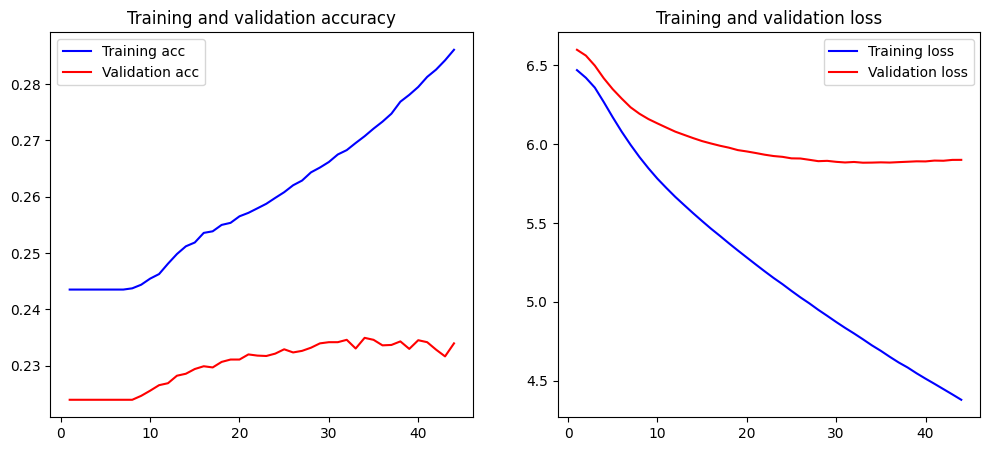

In [33]:
plot_history(history)

In [34]:
X_test.shape, y_test.shape

((225, 128), (225, 65))

In [35]:
y_pred = model.predict([X_test, y_test[:, :-1]])

In [36]:
y_pred.shape

(225, 64, 5497)

In [37]:
y_pred_label = np.argmax(y_pred, axis=-1)

In [38]:
y_pred_label.shape

(225, 64)

In [39]:
def compute_bleu(reference_corpus,
                 translation_corpus,
                 max_order=1,
                 smooth=False):
    def _get_ngrams(segment, max_order):
        ngram_counts = collections.Counter()
        for order in range(1, max_order + 1):
            for i in range(0, len(segment) - order + 1):
                ngram = tuple(segment[i:i + order])
                ngram_counts[ngram] += 1
        return ngram_counts

    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus, translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram) - 1] += overlap[ngram]
        for order in range(1, max_order + 1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order - 1] += possible_matches

    precisions = [0] * max_order
    for i in range(0, max_order):
        if smooth:
            precisions[i] = ((matches_by_order[i] + 1.) /
                             (possible_matches_by_order[i] + 1.))
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = (float(matches_by_order[i]) /
                                 possible_matches_by_order[i])
            else:
                precisions[i] = 0.0

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = float(translation_length) / reference_length

    if ratio > 1.0:
        bp = 1.
    else:
        bp = math.exp(1 - 1. / ratio)

    bleu = geo_mean * bp

    return bleu

In [40]:
from rouge import Rouge
rouge = Rouge()

scores = []
refs = []
hyps = []
for i, j in zip(y_test[:, 1:], y_pred_label):
    temp = [str(t) for t in i]
    refs.append(temp)
    ref = " ".join(temp)
    temp = [str(t) for t in j]
    hyps.append(temp)
    hyp = " ".join(temp)
    try:
        score = rouge.get_scores(hyp, ref)
        scores.append([
            score[0]["rouge-1"]["f"], score[0]["rouge-2"]["f"],
            score[0]["rouge-l"]["f"]
        ])
    except ValueError:
        scores.append([0, 0, 0])
rouge1 = np.mean([i[0] for i in scores])
rouge2 = np.mean([i[1] for i in scores])
rougel = np.mean([i[2] for i in scores])
print("\n" + "*" * 15)
print("The auto evaluation result is:")
print("rouge-1:", round(rouge1, 4))
print("rouge-2:", round(rouge2, 4))
print("rouge-L:", round(rougel, 4))
print("BLEU:", round(compute_bleu(refs, hyps), 4))


***************
The auto evaluation result is:
rouge-1: 0.1384
rouge-2: 0.0615
rouge-L: 0.1249
BLEU: 0.0451
